In [38]:
import glob
import numpy as np
import pandas as pd

import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, SelectFromModel, RFECV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

## 1. Read Data

In [2]:
# Read data
# ---- not concating here in case we want to take a look at a particular date later on

file_names = dict()
for file in glob.glob('../data/*.csv'):
    file_name = file[(file.rfind("/") + 1):(file.rfind("."))].replace("-", "_")
    file_names[file_name] = pd.read_csv(file, parse_dates = ["DateTime"])

In [3]:
# Concat data

data = []
for key in sorted(file_names):
    data.append(file_names[key])
data = pd.concat(data).drop(columns = ["index"])

In [4]:
data.shape

(87124, 64)

## 2. Research Questions

1. Predict whether this minute is "trend" == "up" or "down" using binary classification.
2. Complete feature importance analysis for all indicators.

## 3. Quick EDA - Understanding Predictors

In [5]:
eda_data = data.copy()

# Check if we have data imbalance problem
print(eda_data[eda_data["trend"] == "up"].shape)
print(eda_data[eda_data["trend"] == "down"].shape)

(47219, 64)
(39905, 64)


In [6]:
# Prepare datasets for eda

eda_day_data = {"AAPL_20200214": file_names["AAPL_20200214"].copy(),
                "AAPL_20200408": file_names["AAPL_20200408"].copy(),
                "AAPL_20200313": file_names["AAPL_20200313"].copy(),
                "AAPL_20200316": file_names["AAPL_20200316"].copy()}

for key, df in eda_day_data.items():
    eda_day_data[key]["trend"] = np.where(df["trend"] == "up", 1, 0)
    eda_day_data[key]['DateTime'] = pd.to_datetime(df['DateTime'].apply(
        lambda x: x.strftime("%Y-%m-%d %H-%M-%S")), format="%Y-%m-%d %H-%M-%S")

eda_day_data["AAPL_20200214"].describe()

,index,Open,Close,High,Low,Volume,Previous_Close,MA5_Close,MA9_Close,MA21_Close,MA30_Close,Close_Start_Price_Diff,Open_Start_Price_Diff,Open_Close_Start_Price_Diff,High_Start_Price_Diff,Low_Start_Price_Diff,MA5_Start_Price_Diff,MA9_Start_Price_Diff,MA21_Start_Price_Diff,Close_Start_Price,MA5_Start_Price,MA9_Start_Price,MA21_Start_Price,Close_Trend_5min,Close_Trend_10min,Close_Trend_15min,Close_Trend_20min,Close_Trend_25min,Close_Trend_30min,Close_Trend_35min,Close_Trend_40min,Close_Trend_45min,rsi_24,rsi_12,tsi,stoch,stoch_sig,roc,ao,aroon_indicator,trix,vortex_diff,psar_up,psar_down,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,MACDdiff_12_26_Trend_3min,MACDdiff_12_26_Trend_5min,MACDdiff_12_26_Trend_10min,MACDdiff_12_26_Trend_15min,bb_bbm_20,bb_bbh_20,bb_bbl_20,bb_bbhi_20,bb_bbli_20,bb_bbw_20,bb_bbp_20,atr_14,accDistIndexIndicator,forceIndexIndicator,mfi,vwap,trend
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,3.900000e+02,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.0000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,194.500000,81.136872,81.135974,81.160436,81.111051,1484.217949,8.123000e+01,81.137179,81.136744,81.140359,81.143231,-0.115667,-0.093128,-0.001026,-0.085769,-0.146333,-0.114179,-1.148000,-0.110538,-0.094026,-0.092821,-0.093256,-0.089641,-0.002231,-0.005462,-0.008179,-0.010333,-0.011359,-0.012308,-0.012821,-0.012897,-0.010231,4.932428,49.389783,1.940703,50.544756,50.528611,-0.006697,-0.007662,-11.2000,-0.000321,-0.012236,80.479699,80.734842,-0.003615,-0.004026,0.000410,0.000103,0.000154,0.000282,0.000564,0.004182,0.109035,-0.100670,0.038462,0.064103,0.258460,0.463471,0.046492,15.274430,4.085947,1.255963,-0.115635,0.371795
std,112.727548,0.129833,0.129178,0.129581,0.127764,1323.495070,3.699568e-13,0.126386,0.124063,0.119014,0.114303,0.158912,0.129833,0.040371,0.159467,0.157028,0.155544,1.527181,0.146863,0.129178,0.126386,0.124063,0.119014,0.088002,0.120601,0.147532,0.166229,0.179678,0.189725,0.201042,0.208335,0.200715,0.948431,13.065443,22.427701,30.412945,28.402513,0.132548,0.084075,59.3526,0.008995,0.323607,7.184404,5.877460,0.030286,0.027751,0.010984,0.008514,0.010513,0.014148,0.015878,0.077652,0.086640,0.095723,0.192555,0.245250,0.118409,0.324466,0.017498,3.203147,28.667180,19.530352,0.150131,0.483905
min,0.000000,80.740000,80.750000,80.800000,80.710000,263.000000,8.123000e+01,80.800000,80.860000,80.930000,80.970000,-0.590000,-0.490000,-0.160000,-0.530000,-0.640000,-0.530000,-4.550000,-0.370000,-0.480000,-0.430000,-0.370000,-0.300000,-0.260000,-0.390000,-0.470000,-0.480000,-0.600000,-0.620000,-0.690000,-0.870000,-0.580000,2.968342,18.190622,-37.033573,0.000000,1.851852,-0.393410,-0.214088,-96.0000,-0.013744,-0.844828,-1.000000,-1.000000,-0.080000,-0.070000,-0.020000,-0.020000,-0.030000,-0.030000,-0.040000,-0.236000,-0.055389,-0.517350,0.000000,0.000000,0.000000,-0.210186,0.000000,6.479313,-92.307295,-44.554286,-0.434975,0.000000
25%,97.250000,81.050000,81.050000,81.060000,81.030000,699.250000,8.123000e+01,81.050000,81.050000,81.060000,81.050000,-0.220000,-0.180000,-0.020000,-0.210000,-0.250000,-0.220000,-2.220000,-0.210000,-0.180000,-0.180000,-0.180000,-0.170000,-0.050000,-0.090000,-0.100000,-0.110000,-0.110000,-0.110000,-0.120000,-0.135000,-0.140000,4.354852,39.887355,-11.618348,22.435897,24.536199,-0.098262,-0.054544,-64.0000,-0.003651,-0.264894,81.040000,81.061203,-0.020000,-0.020000,-0.010000,-0.010000,-0.010000,-0.010000,-0.010000,-0.045000,0.044781,-0.136531,0.0

In [7]:
plot_data = eda_day_data["AAPL_20200313"].copy()

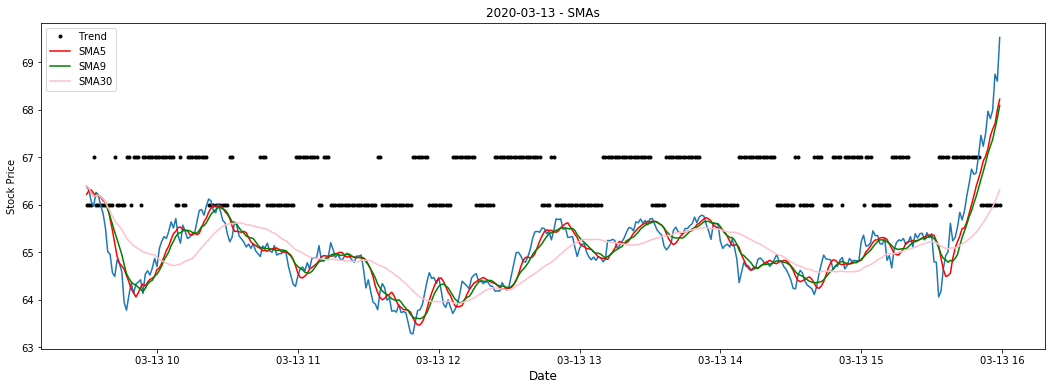

In [8]:
# Combination of MAs at different time windows might be a good indicator of selling/buying
# e.g., trend == "up": most of the pink line is below red/green lines

# Perhaps difference (as a new feature) could be helpful?

f, ax1 = plt.subplots(1, 1, figsize=(18, 6))
ax1.plot(plot_data["DateTime"], plot_data["trend"]+66, ".", color="black", label="Trend")
ax1.plot(plot_data["DateTime"], plot_data["Close"])
ax1.plot(plot_data["DateTime"], plot_data["MA5_Close"], color="red", label="SMA5")
ax1.plot(plot_data["DateTime"], plot_data["MA9_Close"], color="green", label="SMA9")
ax1.plot(plot_data["DateTime"], plot_data["MA30_Close"], color="pink", label="SMA30")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
plt.legend()
ax1.set_title(plot_data.DateTime[0].strftime("%Y-%m-%d")+" - SMAs");

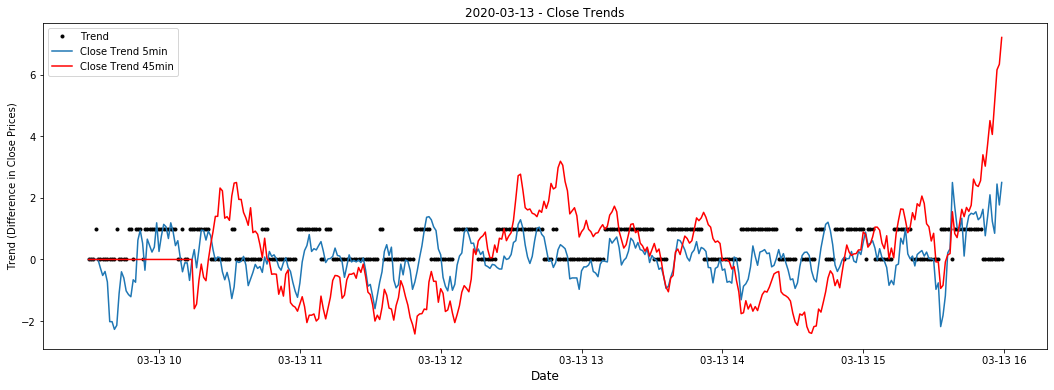

In [9]:
# shorter period trends appear to be more stable (random noise) than longer period trends

f, ax1 = plt.subplots(1, 1, figsize=(18,6))
ax1.plot(plot_data["DateTime"], plot_data["trend"], ".", color="black", label="Trend")
ax1.plot(plot_data["DateTime"], plot_data["Close_Trend_5min"], label="Close Trend 5min")
#ax1.plot(plot_data["DateTime"], plot_data["Close_Trend_10min"], color="blue", label="Close Trend 10min")
#ax1.plot(plot_data["DateTime"], plot_data["Close_Trend_15min"], color="blue", label="Close Trend 15min")
#ax1.plot(plot_data["DateTime"], plot_data["Close_Trend_20min"], color="brown", label="Close Trend 20min")
#ax1.plot(plot_data["DateTime"], plot_data["Close_Trend_25min"], color="blue", label="Close Trend 25min")
#ax1.plot(plot_data["DateTime"], plot_data["Close_Trend_30min"], color="green", label="Close Trend 30min")
#ax1.plot(plot_data["DateTime"], plot_data["Close_Trend_35min"], color="green", label="Close Trend 35min")
#ax1.plot(plot_data["DateTime"], plot_data["Close_Trend_40min"], color="blue", label="Close Trend 40min")
ax1.plot(plot_data["DateTime"], plot_data["Close_Trend_45min"], color="red", label="Close Trend 45min")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Trend (Difference in Close Prices)")
plt.legend()
ax1.set_title(plot_data.DateTime[0].strftime("%Y-%m-%d")+ " - Close Trends");

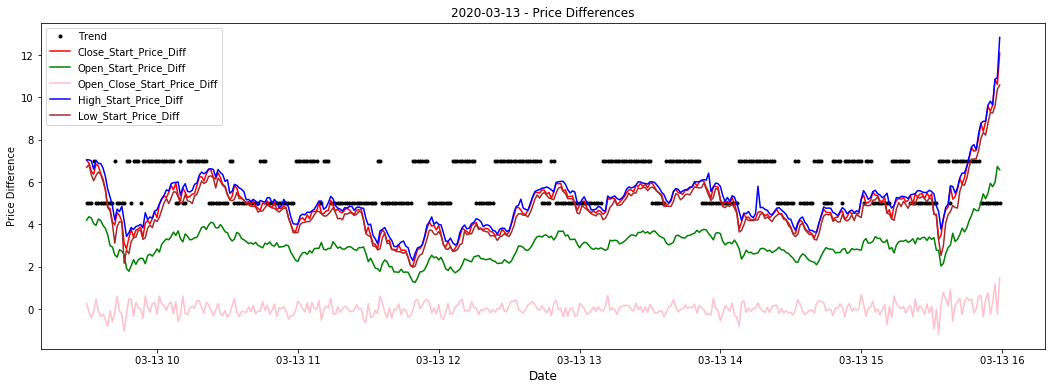

In [10]:
# Pink line looks like random noise
# The other four are highly correlated

f, ax1 = plt.subplots(1, 1, figsize=(18, 6))
ax1.plot(plot_data["DateTime"], plot_data["trend"]*2+5, ".", color="black", label="Trend")
ax1.plot(plot_data["DateTime"], plot_data["Close_Start_Price_Diff"], color="red", label="Close_Start_Price_Diff")
ax1.plot(plot_data["DateTime"], plot_data["Open_Start_Price_Diff"], color="green", label="Open_Start_Price_Diff")
ax1.plot(plot_data["DateTime"], plot_data["Open_Close_Start_Price_Diff"], color="pink", label="Open_Close_Start_Price_Diff")
ax1.plot(plot_data["DateTime"], plot_data["High_Start_Price_Diff"], color="blue", label="High_Start_Price_Diff")
ax1.plot(plot_data["DateTime"], plot_data["Low_Start_Price_Diff"], color="brown", label="Low_Start_Price_Diff")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Price Difference")
plt.legend()
ax1.set_title(plot_data.DateTime[0].strftime("%Y-%m-%d")+ " - Price Differences");

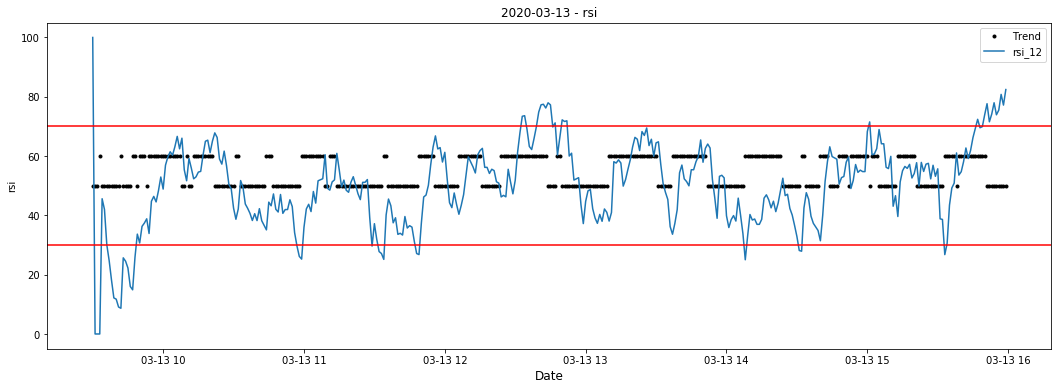

In [11]:
f, ax1 = plt.subplots(1, 1, figsize=(18, 6))
ax1.plot(plot_data["DateTime"], plot_data["trend"]*10+50, ".", color="black", label="Trend")
ax1.plot(plot_data["DateTime"], plot_data["rsi_12"], label="rsi_12")
#ax1.plot(plot_data["DateTime"], plot_data["rsi_24"], color="green", label="rsi_24")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("rsi")
plt.legend()
plt.axhline(y=30, color='red')
plt.axhline(y=70, color='red')
ax1.set_title(plot_data.DateTime[0].strftime("%Y-%m-%d")+ " - rsi");

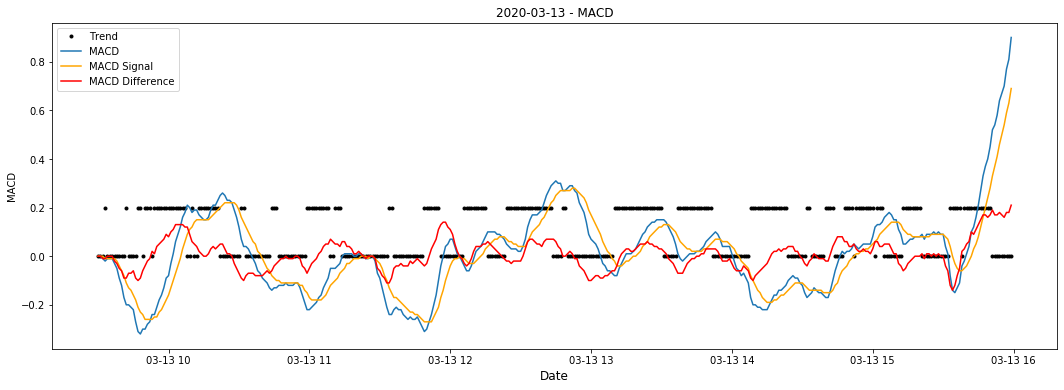

In [12]:
# MACD is supposed to be a good indicator when it acrosses signal
# ---- red line positive

f, ax1 = plt.subplots(1, 1, figsize=(18, 6))
ax1.plot(plot_data["DateTime"], plot_data["trend"]*0.2, ".", color="black", label="Trend")
ax1.plot(plot_data["DateTime"], plot_data["MACD_12_26"], label="MACD")
ax1.plot(plot_data["DateTime"], plot_data["MACDsign_12_26"], color="orange", label="MACD Signal")
ax1.plot(plot_data["DateTime"], plot_data["MACDdiff_12_26"], color="red", label="MACD Difference")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("MACD")
plt.legend()
ax1.set_title(plot_data.DateTime[0].strftime("%Y-%m-%d")+ " - MACD");

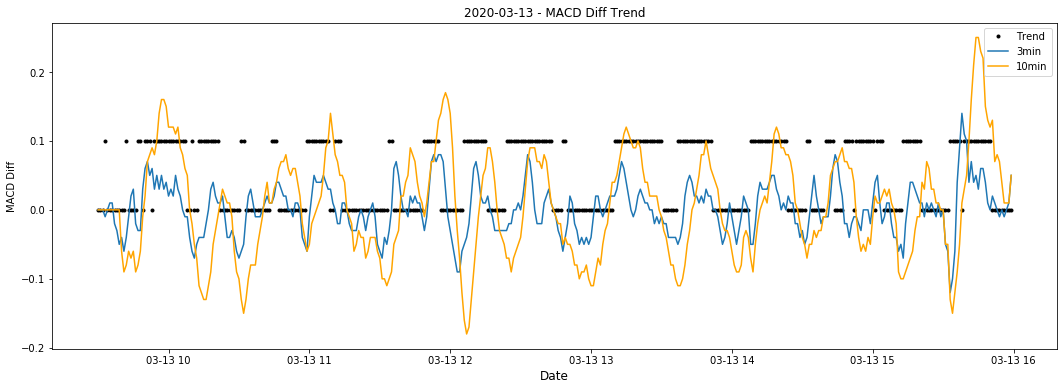

In [13]:
# Does not seem like good predictors, and may be correlated
# ---- 3min seems to be better than 10min

f, ax1 = plt.subplots(1, 1, figsize=(18, 6))
ax1.plot(plot_data["DateTime"], plot_data["trend"]*0.1, ".", color="black", label="Trend")
ax1.plot(plot_data["DateTime"], plot_data["MACDdiff_12_26_Trend_3min"], label="3min")
#ax1.plot(plot_data["DateTime"], plot_data["MACDdiff_12_26_Trend_5min"], color="green", label="5min")
ax1.plot(plot_data["DateTime"], plot_data["MACDdiff_12_26_Trend_10min"], color="orange", label="10min")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("MACD Diff")
plt.legend()
ax1.set_title(plot_data.DateTime[0].strftime("%Y-%m-%d")+ " - MACD Diff Trend");

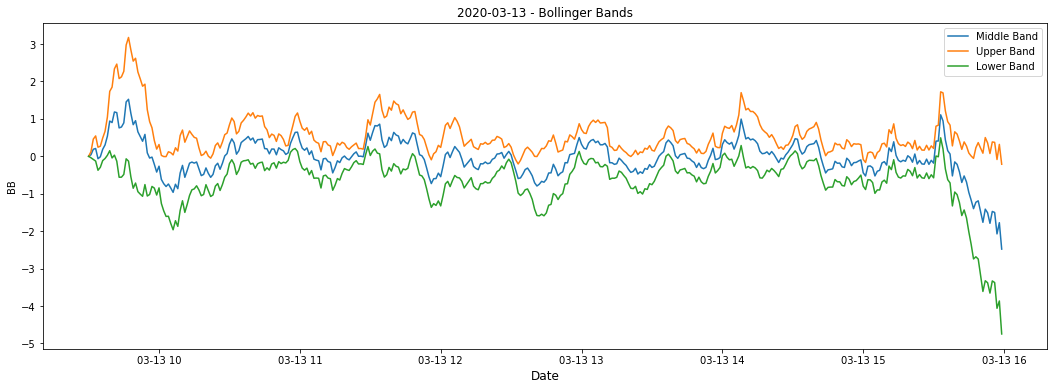

In [14]:
# Should we fit bb_bbhi_20 and bb_bbli_20 as categorical variable?

f, ax1 = plt.subplots(1, 1, figsize=(18, 6))
ax1.plot(plot_data["DateTime"], plot_data["bb_bbm_20"], label="Middle Band")
ax1.plot(plot_data["DateTime"], plot_data["bb_bbh_20"], label="Upper Band")
ax1.plot(plot_data["DateTime"], plot_data["bb_bbl_20"], label="Lower Band")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("BB")
plt.legend()
ax1.set_title(plot_data.DateTime[0].strftime("%Y-%m-%d")+ " - Bollinger Bands");

In [15]:
unuse_col_candidate = ["Open", "High", "Low",
                       "MA21_Close", "Close_Start_Price",
                       "MA5_Start_Price", "MA9_Start_Price", "MA21_Start_Price",
                       "Open_Start_Price_Diff", "High_Start_Price_Diff", "Low_Start_Price_Diff",
                       "Open_Close_Start_Price_Diff", "MA5_Start_Price_Diff", "MA21_Start_Price_Diff",
                       "psar_up", "psar_down",
                       "MACDsign_12_26"]

#eda_data = eda_data[use_cols]

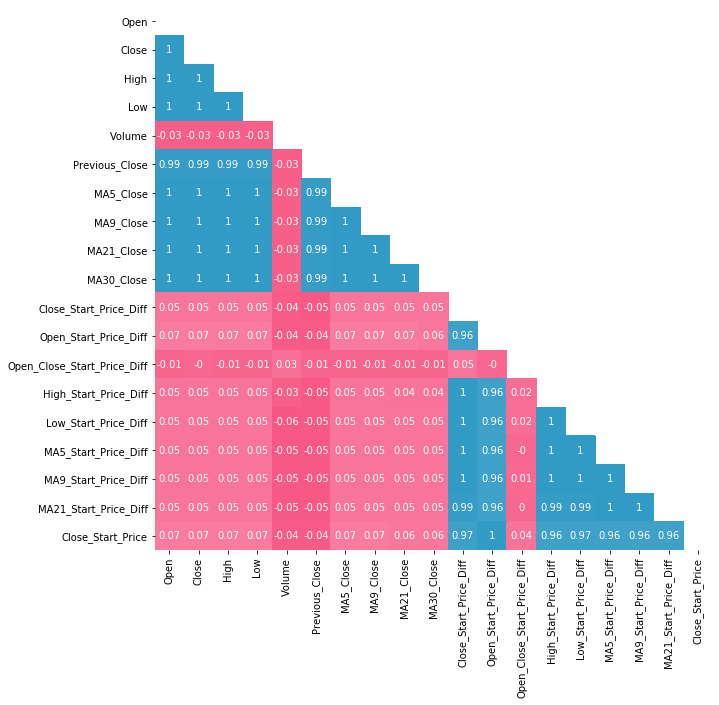

In [46]:
# Although combinations of MAs at different time windows can be useful to track price movements
# ---- they can be highly-correlated and this can affect some non-tree-based models
# ---- plotting a SAMPLE here

corr_heatmap = np.triu(eda_data.iloc[:,:20].corr())
colors = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(ax = ax, data = round(eda_data.iloc[:,:20].corr(), 2), annot=True, mask=corr_heatmap, cmap=colors, cbar=False);

## 4. Train Test Split

In [17]:
# Usually for time series prediction we would want to split by "previous period" vs. "future period"
# ---- but since we are using indicators here to predict price movement for every minute, I suppose we could split randomly

model_data = data.copy()

X, y = model_data.drop(columns=["trend"]), model_data["trend"]

# Make sure we have the same test set every time
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2020
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=0.2, random_state=2021
)


## 5. Preliminary Model

In [18]:
X_train_valid_tmp = X_train_valid.copy().drop(columns=["DateTime"])
X_train_tmp = X_train.copy().drop(columns=["DateTime"])
X_valid_tmp = X_valid.copy().drop(columns=["DateTime"])

In [19]:
lr_pip = Pipeline(steps=[('s', MinMaxScaler()),
                         ('c', LogisticRegression(solver="liblinear"))])
lr_pip.fit(X_train_tmp, y_train)
print(lr_pip.score(X_train_tmp, y_train))
print(lr_pip.score(X_valid_tmp, y_valid))

0.6956013773878823
0.7029021151008362


In [20]:
lgbm = LGBMClassifier().fit(X_train_tmp, y_train)
print(lgbm.score(X_train_tmp, y_train))
print(lgbm.score(X_valid_tmp, y_valid))

0.8032507993768959
0.7847188063616987


In [21]:
# This model is overfitting

clf = RandomForestClassifier()
cv_results = cross_validate(
    clf, X_train_valid_tmp, y_train_valid, cv=3, return_train_score=True)
print(cv_results['train_score'])
print(cv_results['test_score'])

clf.fit(X_train_tmp, y_train)
feat_imp = pd.DataFrame({"Features": list(X_train_tmp.columns),
                         "Importance RF": clf.feature_importances_
                         }).sort_values("Importance RF", ascending=False)
feat_imp


[1. 1. 1.]
[0.80117074 0.79241478 0.7928965 ]


,Features,Importance RF
32,rsi_12,0.040179
34,stoch,0.038574
56,bb_bbp_20,0.035124
31,rsi_24,0.032832
50,bb_bbm_20,0.031024
51,bb_bbh_20,0.026320
35,stoch_sig,0.025869
59,forceIndexIndicator,0.025667
58,accDistIndexIndicator,0.023216
52,bb_bbl_20,0.023161


While features such as "MACDdiff_Trend" are not significant as expected from EDA, signals like "MACD_12_26" or "MACDsign_12_26" were expected to be more powerful than the observed values from the table above.

## 6. Feature Selection

In [22]:
# Method1:  Recursive backward selector - Eliminated features
# ---- check if aligned with EDA results?

rfe_test = [45, 50, 55]

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=54)
rfe.fit(X_train_valid_tmp, y_train_valid)

elim_feat = X_train_valid_tmp.columns[list(~rfe.support_)]
elim_feat

Index(['MACDsign_12_26', 'MACDdiff_12_26', 'MACDdiff_12_26_Trend_3min',
       'MACDdiff_12_26_Trend_5min', 'MACDdiff_12_26_Trend_10min',
       'MACDdiff_12_26_Trend_15min', 'bb_bbhi_20', 'bb_bbli_20'],
      dtype='object')

I also tried to one hot encode bb_bbhi_20 and bb_bbli_20, but it didn't help improve the score. Dropping them from final model.

In [23]:
# Method2: Linear Regression with l1 Regularization
# ---- due to high correlation between features, this method is not used

lr_fs = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight="balanced")

lr_fs_pip = Pipeline(steps=[('s', MinMaxScaler()),
                            ('c', lr_fs)])

lr_fs_pip.fit(X_train_valid_tmp, y_train_valid)
(lr_fs_pip['c'].coef_[0] == 0).sum()

43

In [24]:
# Get rid of unimportant features
# ---- and generate new features


def feat_sel(df):

    df = df.copy().drop(columns=list(elim_feat))
    df["DateTime"] = pd.to_datetime(df["DateTime"].apply(
        lambda x: x.strftime("%Y-%m-%d %H-%M-%S")), format="%Y-%m-%d %H-%M-%S")

    df['hour'] = df.DateTime.dt.hour
    df['minute'] = df.DateTime.dt.minute

    df = df.drop(columns=["DateTime"])

    return df


In [25]:
X_train_valid = feat_sel(X_train_valid)
X_train = feat_sel(X_train)
X_valid = feat_sel(X_valid)
X_test = feat_sel(X_test)

## 7. Model Tuning

### Improve accuracy and fix overfitting:

In [26]:
# Random search over multiple hyper-parameters

random_grid = {'max_depth': [30, 40, 50],
               'min_samples_leaf': [2, 3],
               'n_estimators': [90, 110, 150]}
random_sel = RandomizedSearchCV(estimator=RandomForestClassifier(
), param_distributions=random_grid, n_iter=5, cv=3, verbose=2)

random_sel.fit(X_train_valid, y_train_valid)
random_sel.best_params_


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=90, min_samples_leaf=3, max_depth=50 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=90, min_samples_leaf=3, max_depth=50, total=  19.2s
[CV] n_estimators=90, min_samples_leaf=3, max_depth=50 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s


[CV]  n_estimators=90, min_samples_leaf=3, max_depth=50, total=  19.8s
[CV] n_estimators=90, min_samples_leaf=3, max_depth=50 ...............
[CV]  n_estimators=90, min_samples_leaf=3, max_depth=50, total=  20.0s
[CV] n_estimators=90, min_samples_leaf=2, max_depth=50 ...............
[CV]  n_estimators=90, min_samples_leaf=2, max_depth=50, total=  20.9s
[CV] n_estimators=90, min_samples_leaf=2, max_depth=50 ...............
[CV]  n_estimators=90, min_samples_leaf=2, max_depth=50, total=  22.1s
[CV] n_estimators=90, min_samples_leaf=2, max_depth=50 ...............
[CV]  n_estimators=90, min_samples_leaf=2, max_depth=50, total=  27.2s
[CV] n_estimators=150, min_samples_leaf=3, max_depth=50 ..............
[CV]  n_estimators=150, min_samples_leaf=3, max_depth=50, total=  34.2s
[CV] n_estimators=150, min_samples_leaf=3, max_depth=50 ..............
[CV]  n_estimators=150, min_samples_leaf=3, max_depth=50, total=  32.2s
[CV] n_estimators=150, min_samples_leaf=3, max_depth=50 ..............
[CV]

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  6.7min finished


{'n_estimators': 150, 'min_samples_leaf': 2, 'max_depth': 30}

In [27]:
# Using shallower trees, and less estimators than best parameters to avoid overfitting

clf_fs_hp = RandomForestClassifier(
    max_depth=25, min_samples_leaf=2, n_estimators=110).fit(X_train, y_train)
print(clf_fs_hp.score(X_train, y_train))
print(clf_fs_hp.score(X_valid, y_valid))


0.992641633188489
0.8102967699622889


In [31]:
clf_fs_hp = RandomForestClassifier(
    max_depth=25, min_samples_leaf=2, n_estimators=110).fit(X_train_tmp, y_train)
print(clf_fs_hp.score(X_train_tmp, y_train))
print(clf_fs_hp.score(X_valid_tmp, y_valid))


0.9915553004837255
0.8013608788325955


Validation score after feature selection is better than pre-selection score.

In [29]:
# Gridsearch for max_depth
# ---- use <30 to prevent overfitting

search_grid = {'max_depth': [20, 25, 30]}
sel = GridSearchCV(estimator=RandomForestClassifier(
    min_samples_leaf=2, n_estimators=130), param_grid=search_grid, cv=3, verbose=2)

sel.fit(X_train_valid, y_train_valid)
sel.best_params_


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=20 ....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................................... max_depth=20, total=  27.9s
[CV] max_depth=20 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.9s remaining:    0.0s


[CV] ..................................... max_depth=20, total=  27.6s
[CV] max_depth=20 ....................................................
[CV] ..................................... max_depth=20, total=  27.4s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=  28.9s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=  29.2s
[CV] max_depth=25 ....................................................
[CV] ..................................... max_depth=25, total=  28.7s
[CV] max_depth=30 ....................................................
[CV] ..................................... max_depth=30, total=  29.0s
[CV] max_depth=30 ....................................................
[CV] ..................................... max_depth=30, total=  29.0s
[CV] max_depth=30 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.3min finished


{'max_depth': 30}

## 8. Summary

In [33]:
model = RandomForestClassifier(
    max_depth=20, min_samples_leaf=2, n_estimators=100).fit(X_train_valid, y_train_valid)

print(model.score(X_train_valid, y_train_valid))
print(model.score(X_test, y_test))


0.9711245203817269
0.8082102685744893


In [37]:
model_feat_imp = pd.DataFrame({"Features": list(X_train_valid.columns),
                               "Importance RF": model.feature_importances_
                               }).sort_values("Importance RF", ascending=False)
model_feat_imp.head()

,Features,Importance RF
34,stoch,0.055016
32,rsi_12,0.045046
48,bb_bbp_20,0.042633
44,bb_bbm_20,0.036034
31,rsi_24,0.030543


The train score of the final Random Forest Classifier is 0.97 and the test score is 0.81.

**Steps in this analysis:**
- Performed initial EDA to understand features and their correlations
- Preliminary model fitting: tried 3 models (Logistic Regression, LGBM, and Random Forest), Random Forest appeared to be the best
- Feature selection: used backward selection with a Random Forest estimator
- Model tuning: used both train and validation for model tuning to avoid overfitting

**Feature Importance:**
- The 5 most important features are: Stochastic Oscillator, RSI_12, Bollinger Channel Percentage Band, Bollinger Channel Middle Band, and RSI_24
- It's interesting to see to predict current minute up/down, trends are not as important as momentum or volatility indicators
- I've seen price forecasting using recurrent network relying solely on past observations. But in this case technical indicators seem to be more powerful.

**Future Improvements:**
- More data
- In feature selection section, try drop out more features (run time will increase)
- More hyper-parameters to be tuned